In [1]:
import os
from collections import OrderedDict
import logging
from functools import partial

import numpy as np
from astropy.table import Table as ApTable

import proxmin
import deblender

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

logger = logging.getLogger("deblender")
logger.setLevel(logging.INFO)
logger2 = logging.getLogger("proxmin")
logger2.setLevel(logging.INFO)

In [13]:
# Load the data
_images = np.load("../data/test_sim/images_3.npz")
images = _images["images"]
# Don't forget to make sure that the images has odd columns and rows
images = deblender.nmf.reshape_img(images)
filters = _images["filters"]
_psfs = np.load("../data/test_sim/psfs.npz")
psfs = _psfs["psfs"]
if np.all(_psfs["filters"]!=filters):
    raise Exception("PSF and image filters do not match")
catalog = ApTable.read("../data/test_sim/true_catalog_3.fits")

In [14]:
_peaks = np.array([np.array(catalog["x"]), np.array(catalog["y"])]).T
# For now, only use a single component for each object
src_list = np.unique(catalog["index"])
peaks = np.zeros((len(src_list), 2))
for sid in src_list:
    src = catalog[catalog["index"]==sid][0]
    peaks[sid] = [src["x"], src["y"]]

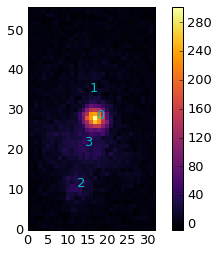

In [16]:
plt.imshow(images[0])
plt.colorbar()
for n, (px,py) in enumerate(peaks):
    plt.text(px, py, str(n), color='c')
plt.xlim([0,images[0].shape[1]-1])
plt.ylim([0, images[0].shape[0]-1])
plt.show()

In [19]:
l0_thresh=5e-4
l1_thresh = None
strict_constraints = "m"
B, N, M = images.shape

if l0_thresh is None and l1_thresh is None:
    prox_S = proxmin.operators.prox_plus
else:
    # L0 has preference
    if l0_thresh is not None:
        if l1_thresh is not None:
            logger.warn("weights warning: l1_thresh ignored in favor of l0_thresh")
        prox_S = partial(proxmin.operators.prox_hard, thresh=l0_thresh)
    else:
        prox_S = partial(proxmin.operators.prox_soft_plus, thresh=l1_thresh)
if isinstance(strict_constraints, str):
    if strict_constraints!="m":
        raise ValueError("Monotonicity 'm' is the only allowed strict constraint")
    seeks = [True]*len(peaks)
else:
    seeks = [strict_constraints[pk] for pk in range(peaks)]
prox_S = deblender.proximal.build_prox_monotonic(shape=(N,M), seeks=seeks,
                                                 prox_chain=prox_S)

In [20]:
result = deblender.nmf.deblend(
    images,
    peaks=peaks,
    constraints=["S"]*len(peaks),
    psf=None,
    max_iter=100,
    e_rel=1e-2,
    l0_thresh=5e-4,
    traceback=False,
    prox_S=prox_S
)

INFO:proxmin.algorithms:Completed 101 iterations


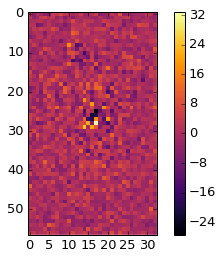

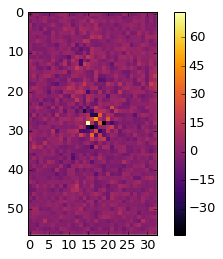

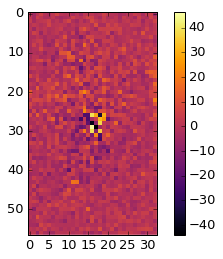

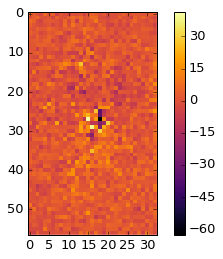

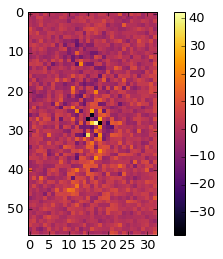

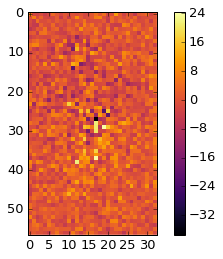

In [23]:
model = result.get_model(combine=True)
for i in range(len(model)):
    plt.imshow(result.img[i]-model[i])
    plt.colorbar()
    plt.show()

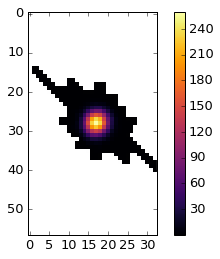

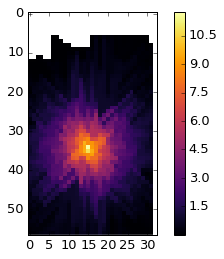

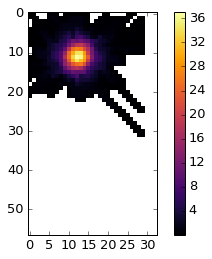

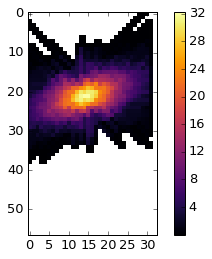

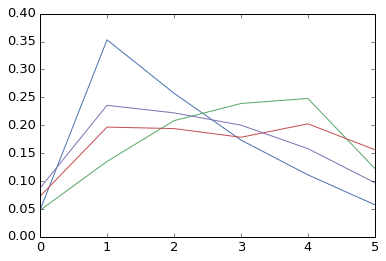

In [24]:
A, S, Gamma = result.A, result.S, result.T.Gamma
for k in range(len(S)):
    model = deblender.nmf.get_peak_model(A, S, Gamma, shape=(S[k].shape), k=k)[0]
    plt.imshow(np.ma.array(model, mask=model==0))
    plt.colorbar()
    plt.show()
for k in range(A.shape[1]):
    plt.plot(A[:,k])
plt.show()